In [125]:
import os

import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import transforms

from miniai.imports import *
from miniai.activations import *
from miniai.datasets import *
from miniai.diffusion import *

In [126]:
"GPU is there" if torch.cuda.is_available() else Exception("GPU is missing") 

'GPU is there'

### Get Tiny ImageNet

In [127]:
path_t = Path("tiny_imgnet/train")
path_v = Path("tiny_imgnet/valid")

In [128]:
# Original MemmapDataset in 10_AttentionCondUNet.ipynb
class MemmapDataset(Dataset):
    def __init__(self, path, num_elems, useImg=False, useEmb=True, useLat=True,
                 img_filename="tensor_imgs.npmm" ,emb_filename="tensor_embs.npmm", lat_filename="tensor_lats.npmm", 
                 img_shape=(3,64,64), emb_shape=(768), lat_shape=(4,8,8)):

        self.num_elems = num_elems
        self.useImg = useImg
        self.useEmb = useEmb
        self.useLat = useLat

        if useImg:
            path_img = path/img_filename
            self.img_shape = (num_elems, *(img_shape))
            self.imgs = np.memmap(path_img, dtype=np.float32, mode='r', shape=self.img_shape)

        if useEmb:
            path_emb = path/emb_filename
            self.emb_shape = (num_elems, emb_shape)
            self.embs = np.memmap(path_emb, dtype=np.float32, mode='r', shape=self.emb_shape)

        if useLat:
            path_lat = path/lat_filename        
            self.lat_shape = (num_elems, *(lat_shape))
            self.lats = np.memmap(path_lat, dtype=np.float32, mode='r', shape=self.lat_shape)

    def __len__(self):
        return self.num_elems

    def __getitem__(self, i):
        return torch.tensor(self.imgs[i])

In [129]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    eps = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*eps
    return (xt, t.to(device)), eps

In [130]:
def custom_collate(b):
    img = default_collate(b)
    return noisify(img)

In [131]:
def custom_dl(ds):
    return DataLoader(ds, batch_size=32, collate_fn=custom_collate, num_workers=0)

In [132]:
tds = MemmapDataset(path_t, 100_000, True, False, False)
vds = MemmapDataset(path_v, 10_000, True, False, False)

In [133]:
# Select only 64x64 fish images from the dataset
tfish = tds[:500]
vfish = vds[:50]

In [134]:
dls = DataLoaders(custom_dl(tfish), custom_dl(vfish))

In [135]:
(noised_img, timestep), true_noise = next(iter(dls.train))
noised_img.shape, timestep.shape, true_noise.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]), torch.Size([32, 3, 64, 64]))

In [136]:
class UncondUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1, attn_chans=8, attn_start=2):
        super().__init__()

        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        
        # In Conv
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)

        # Down Blocks
        self.downs = nn.ModuleList()
        n = len(nfs)
        for i in range(n):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=n-1, num_layers=num_layers,
                                        attn_chans=0 if i<attn_start else attn_chans))
            
        # Mid Blocks
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        # Up Blocks
        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(n):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=n-1, num_layers=num_layers+1,
                                    attn_chans=0 if i>=n-attn_start else attn_chans))
            
        # Out Conv
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t = inp
        temb = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(temb)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

### Debugging
- I noticed that my model would produce nan loss when it would train on my GPU (this was not the case for CPU).
- No matter the learning rate (1e-3, 1e-9, 0.0), loss was still nan.

- The data did not have any nan or inf values.
- The loss function did not produce any nan or inf values.
- None of the model parameters had any nan or inf values.
- I did find that the output of the model nan values and as a result, the gradients were nan, and loss became nan.
- I used hooks to see when the activations in the model became nan and it seems like the first instance is at the end of the first upblock in the model. nn.Upsample(scale_factor=2.0, mode='nearest') produces non-nan values, but nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) seemed to produce some nan values and this cascades to make the rest of the activations nan as well, resulting in a nan output.
- I took the output of the upsampling layer and fed it into the convolutional layer and was able to reproduce the error.

In [137]:
# Check if data has any inf or nan
# no output = no inf or nan values
batch = 0
for i in dls.train:
    # Is nan?
    if i[0][0].isnan().any():
        print(f"Nan in {batch} for x")
    if i[0][1].isnan().any():
        print(f"Nan in {batch} for t")
    if i[1].isnan().any():
        print(f"Nan in {batch} for y")

    # Is inf?
    if i[0][0].isinf().any():
        print(f"Inf in {batch} for x")
    if i[0][1].isinf().any():
        print(f"Inf in {batch} for t")
    if i[1].isinf().any():
        print(f"Inf in {batch} for y")

In [138]:
# Check loss for any nan or inf values
for batch in dls.train:
    loss_fn = nn.MSELoss()
    loss = loss_fn(batch[0][0], batch[1])
    print(loss)

tensor(0.3473)
tensor(0.3385)
tensor(0.4712)
tensor(0.3335)
tensor(0.3628)
tensor(0.2971)
tensor(0.4043)
tensor(0.3903)
tensor(0.3024)
tensor(0.4244)
tensor(0.3274)
tensor(0.3093)
tensor(0.3192)
tensor(0.3152)
tensor(0.3097)
tensor(0.2741)


In [139]:
# Check if model params have any inf or nan
# no output = no inf or nan values
for i,j in model.named_parameters():
    # Is nan?
    if j.isnan().any():
        print(f"Nan in {i}")

    # Is inf?
    if j.isinf().any():
        print(f"Inf in {i}")

In [222]:
set_seed(42)
model = UncondUnet(in_channels=3, out_channels=3, nfs=(16,32,48,64), num_layers=1, attn_chans=0).to("cuda")
#init_ddpm(model)

In [224]:
# Check output and gradients for nan values
b = next(iter(dls.train))
b = (b[0][0].to("cuda"), b[0][1].to("cuda")), b[1].to("cuda")

# Compute output
print(f"input: {b[0]}")
output = model(b[0])
#print(output)

# Compute grads
loss_fn = nn.MSELoss()
loss = loss_fn(output, b[1])
loss.backward()
param = next(iter(model.parameters()))
#print(param.grad)

input: (tensor([[[[ 1.4370,  0.4304,  0.7563,  ...,  0.7934,  0.6050,  0.7306],
          [ 1.6701,  0.7784,  1.1776,  ...,  1.5163,  1.0648,  0.0794],
          [ 1.4688,  0.9945,  0.5443,  ...,  0.8528,  0.7475, -0.0432],
          ...,
          [ 0.6449,  0.2152,  0.7027,  ...,  0.1716,  0.4654,  0.2040],
          [ 0.4715,  0.2035,  1.1093,  ..., -0.3481,  0.2525,  0.3245],
          [ 0.4026,  0.7611,  1.1934,  ...,  0.1206,  0.2310, -0.0997]],

         [[ 0.4297, -0.2408,  0.2674,  ...,  0.5725,  0.5993,  0.9012],
          [-0.1201,  0.1690,  0.7651,  ..., -0.1427,  0.5627,  0.5266],
          [ 0.4189,  0.0805,  0.7820,  ...,  0.7868,  1.2962,  1.0699],
          ...,
          [-0.2694,  0.7975,  1.1410,  ...,  0.1552,  0.1675,  0.5030],
          [ 0.2458,  0.1998,  0.2531,  ...,  0.7267,  0.6130, -0.0062],
          [ 1.1715,  1.3455,  0.7978,  ..., -0.0249,  0.0873, -0.9133]],

         [[ 1.3019,  0.1870,  0.7136,  ...,  0.8047,  0.6199,  0.4736],
          [ 0.9267,  0

In [225]:
"""unique_classes = set()

for layer in model.modules():
    layer_class = layer.__class__
    if layer_class not in unique_classes:
        unique_classes.add(layer_class)
        print(layer_class)"""


'unique_classes = set()\n\nfor layer in model.modules():\n    layer_class = layer.__class__\n    if layer_class not in unique_classes:\n        unique_classes.add(layer_class)\n        print(layer_class)'

In [226]:
activation_log = {}

"""def nan_activation_hook(module, input, output):
    if torch.isnan(output).any() or torch.isinf(output).any():
        print(f"NaN or Inf detected in {module}")
        print(output)"""

def is_pytorch_layer(layer):
    return isinstance(layer, (nn.BatchNorm1d, nn.SiLU, nn.Linear, nn.Conv2d, 
                              nn.BatchNorm2d, nn.Identity, nn.Upsample))

def activation_hook(module, input, output):
    activation_log[module] = output

def nan_activation_hook(module, input, output):
    if torch.isnan(output).any() or torch.isinf(output).any():
        activation_log[module] = "NaN or Inf detected"
    else:
        activation_log[module] = "OK"

def average_act(module, input, output):
    activation_log[module] = output.mean()
    
for layer in model.modules():
    if is_pytorch_layer(layer):
        layer.register_forward_hook(activation_hook)


In [227]:
# Run a forward pass to populate the log
b = next(iter(dls.train))
b = (b[0][0].to("cuda"), b[0][1].to("cuda")), b[1].to("cuda")

with torch.no_grad():
    output = model(b[0])

# Check the log for layers with issues
for layer_name, status in activation_log.items():
    print(f"{layer_name}: {status}")

BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True): tensor([[-2.9764e-01, -3.4324e-01, -3.4254e-01, -3.0164e-01, -1.4839e-01,
         -4.3695e-02, -1.1809e-02, -3.1698e-03,  5.5331e-01,  5.3360e-01,
          1.2686e-01,  9.3853e-03,  6.7855e-04,  5.6546e-05,  0.0000e+00,
          0.0000e+00],
        [ 3.0987e-01,  2.3456e-01,  2.2717e-01,  1.9962e-01,  9.8184e-02,
          2.8911e-02,  7.8138e-03,  2.0973e-03,  5.6568e-02,  7.4216e-02,
          1.7953e-02,  1.3381e-03,  9.4243e-05,  1.8849e-05,  0.0000e+00,
          0.0000e+00],
        [ 1.2265e+00,  1.2227e+00,  1.2094e+00,  1.0644e+00,  5.2357e-01,
          1.5417e-01,  4.1668e-02,  1.1184e-02, -1.2193e+00, -1.1534e+00,
         -2.7388e-01, -2.0222e-02, -1.4513e-03, -9.4243e-05, -1.8849e-05,
          0.0000e+00],
        [-1.4039e+00, -1.3317e+00, -1.3130e+00, -1.1552e+00, -5.6824e-01,
         -1.6733e-01, -4.5223e-02, -1.2139e-02,  9.4248e-01,  8.8680e-01,
          2.1048e-01,  1.5567e-02,  

In [228]:
upsample_output.shape

torch.Size([32, 64, 16, 16])

In [229]:
# Get first upsample output
upsample_output = None
for layer_name, tensor in activation_log.items():
    if isinstance(layer_name, nn.Upsample):
        upsample_output = tensor
        break
upsample_output.to(torch.float32)

# Get conv layer causing nan output
conv = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)).to(torch.float32).to("cuda")

with torch.no_grad():
    test = conv(upsample_output)
test

tensor([[[[ 8.6784e-05,  8.6784e-05,  8.6784e-05,  ...,         nan,
            8.6784e-05,  7.1585e-05],
          [ 7.1585e-05,         nan,         nan,  ...,  8.6784e-05,
            8.6784e-05,         nan],
          [ 8.6784e-05,         nan,         nan,  ...,  8.6784e-05,
            8.6784e-05,         nan],
          ...,
          [ 8.6784e-05,  8.6784e-05,  7.1585e-05,  ...,         nan,
            7.1585e-05,  8.6784e-05],
          [ 8.6784e-05,  8.6784e-05,  8.6784e-05,  ...,         nan,
            8.6784e-05,  8.6784e-05],
          [ 8.6784e-05,  8.6784e-05,  7.1585e-05,  ...,  8.6784e-05,
            7.1585e-05,  8.6784e-05]],

         [[-8.9951e-03, -8.9951e-03, -8.9951e-03,  ..., -8.9951e-03,
           -8.9951e-03, -8.9951e-03],
          [-8.9951e-03, -8.9951e-03, -8.9951e-03,  ..., -8.9951e-03,
           -8.9951e-03, -8.9951e-03],
          [-8.9951e-03, -8.9951e-03, -8.9951e-03,  ..., -8.9951e-03,
           -8.9951e-03, -8.9951e-03],
          ...,
     

In [230]:
import torch
print(torch.version.cuda)  # CUDA version used by PyTorch
print(torch.cuda.is_available())  # Check if CUDA is available


11.7
True


In [220]:
# Use random values to ensure
#x = torch.rand_like(upsample_output)
x = torch.rand((32,64,16,16)).to(torch.float32).to("cuda")

# Get conv layer causing nan output
conv = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)).to(torch.float32).to("cuda")

with torch.no_grad():
    test = conv(x)
test

tensor([[[[    nan,     nan,  0.0310,  ...,     nan,  0.0310,  0.0310],
          [    nan,  0.0310,     nan,  ...,  0.0310,     nan,  0.0310],
          [    nan,  0.0310,  0.0310,  ...,  0.0310,     nan,  0.0310],
          ...,
          [    nan,  0.0310,     nan,  ...,     nan,     nan,  0.0310],
          [    nan,  0.0310,  0.0310,  ...,  0.0310,     nan,  0.0310],
          [ 0.0310,     nan,  0.0310,  ...,     nan,  0.0310,  0.0310]],

         [[-0.0250, -0.0250, -0.0250,  ..., -0.0250, -0.0250, -0.0250],
          [-0.0250, -0.0250, -0.0250,  ..., -0.0250, -0.0250, -0.0250],
          [-0.0250, -0.0250, -0.0250,  ..., -0.0250, -0.0250, -0.0250],
          ...,
          [-0.0250, -0.0250, -0.0250,  ..., -0.0250, -0.0250, -0.0250],
          [-0.0250, -0.0250, -0.0250,  ..., -0.0250, -0.0250, -0.0250],
          [-0.0250, -0.0250, -0.0250,  ..., -0.0250, -0.0250, -0.0250]],

         [[    nan,     nan,  0.0058,  ...,  0.0058,     nan,     nan],
          [    nan,     nan,  

In [221]:
test.shape

torch.Size([32, 64, 16, 16])

In [217]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
num_params

814608

### Train

In [13]:
def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [14]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig, clamp=True):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt())
    if clamp: x_0_hat = x_0_hat.clamp(-1,1)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

In [15]:
@torch.no_grad()
def sample(f, model, sz, steps, eta=1., clamp=True, progress=False):
    model.eval()
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).cuda()
    preds = []
    tbe = ts if progress else ts 
    for i,t in enumerate(tbe):
        t = t[None].cuda()
        abar_t = abar(t)
        noise = model((x_t, t))
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100), clamp=clamp)
        preds.append(x_0_hat.float().cpu())
    return preds

In [16]:
lr = 1e-10
epochs = 20
opt_func = partial(optim.Adam, eps=1e-5)

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR,max_lr=lr, total_steps=tmax)
astats = ActivationStats(fc.risinstance(nn.SiLU))
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), MixedPrecision(), astats]

model = UncondUnet(in_channels=3, out_channels=3, nfs=(16,32,48,64), num_layers=1, attn_chans=0)
init_ddpm(model)

learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
nan,0,train
nan,0,eval
nan,1,train
nan,1,eval


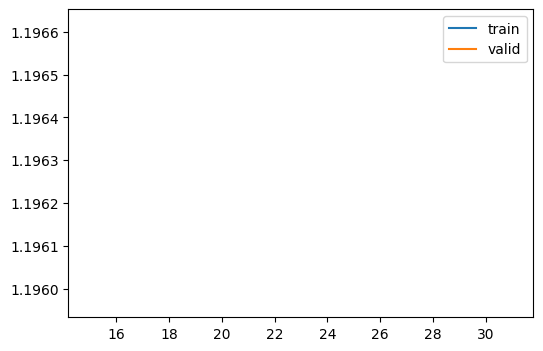

KeyboardInterrupt: 

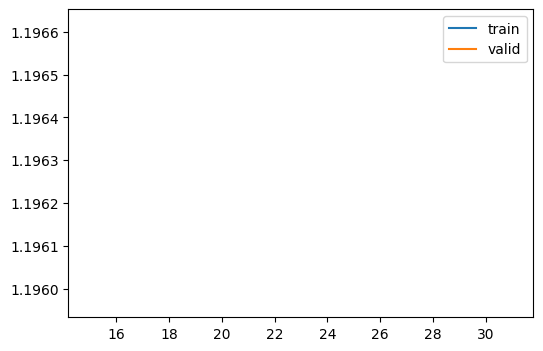

In [17]:
learn.fit(epochs)

In [30]:
model.state_dict()

OrderedDict([('emb_mlp.0.0.weight',
              tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
                     device='cuda:0')),
             ('emb_mlp.0.0.bias',
              tensor([ 3.2737e-13, -2.8708e-13,  2.8625e-13, -6.2089e-13,  0.0000e+00,
                      -1.7364e-13,  0.0000e+00,  0.0000e+00, -2.6375e-14,  1.4109e-14,
                      -2.8506e-14,  1.5160e-13,  1.4856e-13,  0.0000e+00,  2.9713e-13,
                      -1.4879e-13], device='cuda:0')),
             ('emb_mlp.0.0.running_mean',
              tensor([3.9464e-01, 1.1476e-01, 3.0963e-02, 8.3099e-03, 2.2294e-03, 5.9807e-04,
                      1.6044e-04, 4.3042e-05, 7.1136e-01, 8.3945e-01, 8.4915e-01, 8.4985e-01,
                      8.4990e-01, 8.4990e-01, 8.4991e-01, 8.4991e-01], device='cuda:0')),
             ('emb_mlp.0.0.running_var',
              tensor([0.2043, 0.1553, 0.1505, 0.1501, 0.1501, 0.1501, 0.1501, 0.1501, 0.1674,
                      0.1502, 0.